In [ ]:
%pip install tqdm scikit-learn pandas matplotlib
%pip install torch --index-url https://download.pytorch.org/whl/cu118

Dataset is the apple quality dataset from kaggle:
https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality

In [620]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

df = pd.read_csv('apple_quality.csv') 
df

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
...,...,...,...,...,...,...,...,...,...
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


In [621]:
# Drop rows with missing values
df.dropna(inplace=True)
df.notna().sum()

A_id           4000
Size           4000
Weight         4000
Sweetness      4000
Crunchiness    4000
Juiciness      4000
Ripeness       4000
Acidity        4000
Quality        4000
dtype: int64

In [622]:
# Convert the 'Quality' column to numeric labels
from sklearn.preprocessing import LabelEncoder
labels = df['Quality']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
df.drop(columns=['Quality', 'A_id'], inplace=True)
num_labels = len(set(labels))
num_labels

2

In [623]:
num_features = df.shape[1]
num_features

7

In [624]:
from sklearn.model_selection import train_test_split
train_X_tensor, val_X, train_y_tensor, val_y = train_test_split(df.to_numpy(dtype=float), np.array(labels), test_size=0.2, random_state=42)
train_X, test_X, train_y, test_y = train_test_split(train_X_tensor, train_y_tensor, test_size=0.1, random_state=42)

print(f"Train size: {train_X.shape[0]}")
print(f"Validation size: {val_X.shape[0]}")
print(f"Test size: {test_X.shape[0]}")

Train size: 2880
Validation size: 800
Test size: 320


In [625]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)
test_X = scaler.transform(test_X)

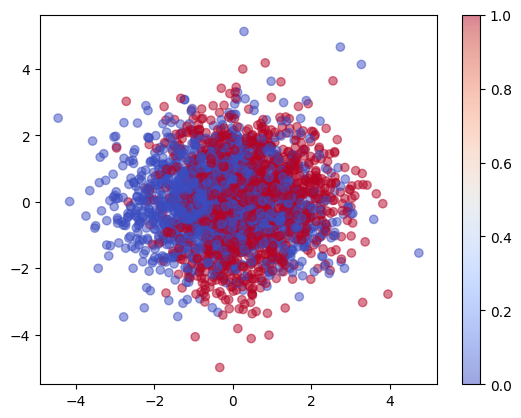

In [626]:
# pca to view the data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_X)
train_X_pca = pca.transform(train_X)

plt.scatter(train_X_pca[:, 0], train_X_pca[:, 1], c=train_y, cmap='coolwarm', alpha=0.5)
plt.colorbar()
plt.show()

# Part 1: NN from scratch

Loss: 0.0625: 100%|██████████| 2000/2000 [00:09<00:00, 213.90it/s]


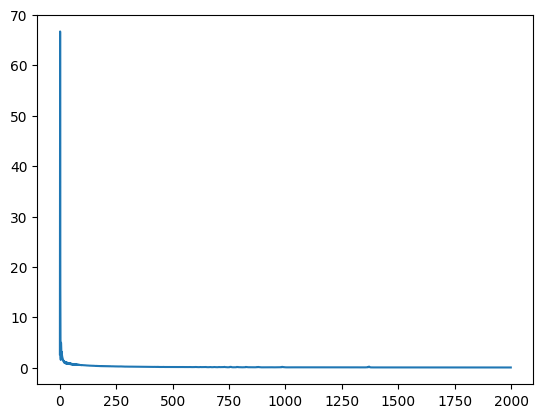

In [627]:
# from scratch
class Net_Scratch():
    def __init__(self, num_features, num_labels, hidden_size):
        self.W1 = np.random.randn(num_features, hidden_size)
        self.b1 = np.random.randn(hidden_size)
        self.W2 = np.random.randn(hidden_size, num_labels)
        self.b2 = np.random.randn(num_labels)
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return self.z2
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)
    
    def cost(self, y_pred, y):
        # cross entropy loss
        m = y.shape[0]
        p = self.sigmoid(y_pred)
        log_likelihood = -np.log(p[range(m), y])
        loss = np.sum(log_likelihood) / m
        return loss

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self, z):
        a = self.sigmoid(z)
        return a * (1 - a)

    def backward(self, X, y):
        m = X.shape[0]
        p = self.sigmoid(self.z2)
        p[range(m), y] -= 1
        self.dW2 = self.a1.T @ p
        self.db2 = np.sum(p, axis=0)
        p = p @ self.W2.T * self.sigmoid_prime(self.z1)
        self.dW1 = X.T @ p
        self.db1 = np.sum(p, axis=0)
    
    def train(self, X, y, learning_rate=0.01, epochs=1000):
        tqdm_epochs = tqdm(range(epochs))
        history = []
        for epoch in tqdm_epochs:
            y_pred = self.forward(X)
            self.backward(X, y)
            self.W1 -= learning_rate * self.dW1
            self.b1 -= learning_rate * self.db1
            self.W2 -= learning_rate * self.dW2
            self.b2 -= learning_rate * self.db2
            loss = self.cost(y_pred, y)
            history.append(loss)
            tqdm_epochs.set_description(f"Loss: {loss:.4f}")
        return history

net = Net_Scratch(num_features, num_labels, 100)
history = net.train(train_X, train_y, learning_rate=0.01, epochs=2000)
plt.plot(history)
plt.show()

In [628]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(test_X)
my_nn_acc = accuracy_score(test_y, y_pred)
print(f"Accuracy: {my_nn_acc:.4f}")

Accuracy: 0.9031


# Part 2: With PyTorch
## Task 1:
I need the following:
- The nn module for the definition of the layers in the NN and the loss function
- The optim module for the optimizers (SGD, Adam, etc.)

## Task 2: Implementation

cuda


 12%|█▏        | 246/2000 [00:00<00:02, 800.98it/s, epoch loss=0.0632] 


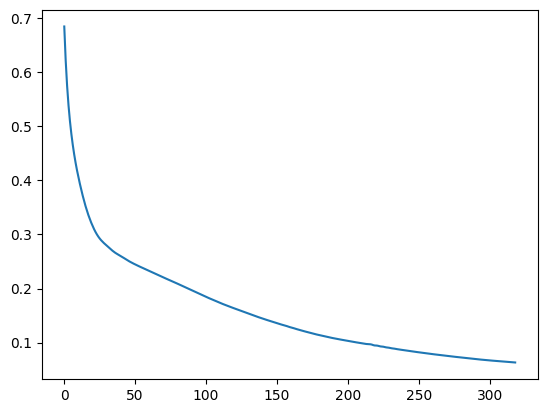

In [629]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# multiclass classification with a 2-layer neural network
class Net(nn.Module):
    class EarlyStopper:
        def __init__(self, patience=1, min_delta=0):
            self.patience = patience
            self.min_delta = min_delta
            self.counter = 0
            self.min_validation_loss = float('inf')

        def early_stop(self, validation_loss):
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False


    def __init__(self, input_size, num_classes, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            return torch.argmax(x, dim=1)
    
    def train(self, X, y, epochs=10, lr=0.001, reg_param=0.0, batch_size=16, val_X=None, val_y=None):
        history = []
        average_loss_history = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=reg_param)
        if val_X is not None and val_y is not None:
            early_stopper = self.EarlyStopper(patience=10, min_delta=1e-6)
        tqdm_epochs = tqdm(range(epochs))
        for epoch in tqdm_epochs:
            for batch in range(0, len(X), batch_size):
                X_batch = X[batch:batch+batch_size]
                y_batch = y[batch:batch+batch_size]
                optimizer.zero_grad()
                output = self(X_batch)
                loss = criterion(output, y_batch)
                history.append(loss.item())
                loss.backward()
                optimizer.step()
            if val_X is not None and val_y is not None:
                val_output = self(val_X)
                val_loss = criterion(val_output, val_y).item()
                if early_stopper.early_stop(val_loss):
                    tqdm_epochs.close()
                    break
            average_loss = np.mean(history[-len(X)//batch_size:])
            average_loss_history.append(average_loss)
            tqdm_epochs.set_postfix({'epoch loss': average_loss})
        return history, average_loss_history
        
net = Net(num_features, num_labels, hidden_size=100).to(device)
train_X_tensor = torch.tensor(train_X).float().to(device)
train_y_tensor = torch.tensor(train_y).long().to(device)
val_X_tensor = torch.tensor(val_X).float().to(device)
val_y_tensor = torch.tensor(val_y).long().to(device)
_, history = net.train(train_X_tensor, train_y_tensor, epochs=2000, lr=1e-2, reg_param=0.0001, batch_size=len(train_X), val_X=val_X_tensor, val_y=val_y_tensor)
plt.plot(history)
plt.show()

In [632]:
y_pred = net.predict(torch.tensor(test_X).float().to(device))
torch_acc = accuracy_score(test_y, y_pred.cpu().numpy())
print(f"Accuracy: {torch_acc:.4f}")

Accuracy: 0.9125


## Task 3: Hyperparameter tuning
I selected the hyperparameters really just by playing around with them until it gave a good result on the validation set. I did use L2 regularization because its good practice to in order keep the model generalization good. I used Adam instead of SGD due to its ease of implementation and its fast convergence speed from using momentum and adaptive learning rate.

A better way to find the hyperparameters would be to use another validation set to do CV for the hyperparameter search but my implementation was having efficiency issues and was not giving good accuracy.

## Task 4: (graduate level)

In [631]:
# with tree-based model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(train_X, train_y)
rf_acc = rf.score(test_X, test_y)

print(f"My NN accuracy: {my_nn_acc:.4f}")
print(f"Torch NN accuracy: {torch_acc:.4f}")
print(f"Random Forest accuracy: {rf_acc:.4f}")

My NN accuracy: 0.9031
Torch NN accuracy: 0.9125
Random Forest accuracy: 0.8688


One of the potential reasons for the low accuracy of the tree based model is that the data is not linearly separable. We can see that from the PCA plot.
Another reason might be that the tree-based model is not able to capture the interactions between the features.